## SOCIAL HEALTH AUTHORITY(SHA) CHATBOT

## Business Understanding
The Social Health Authority (SHA), is tasked with ensuring that millions of Kenyans have access to essential health insurance information and services. The SHA chatbot project aims to streamline the flow of information by providing immediate, accurate responses to frequently asked questions (FAQs). The chatbot addresses a critical need for accessible information, especially for users who may not have the time or ability to navigate SHA’s full range of resources.

### Real-World Problem
SHA’s customer service team handles high volumes of repetitive inquiries regarding health insurance coverage, registration, benefits, eligibility, and more. This overload places strain on customer service teams, potentially delaying responses and impacting customer satisfaction. Many people seeking answers to simple questions may have to endure wait times or face difficulties finding information online, creating barriers to healthcare access.


This project aims to solve the problem of information bottlenecks by implementing a chatbot capable of providing rapid, consistent answers to common questions. By using the SHA chatbot, users can access information at any time, receive responses instantly, and have a better experience interacting with SHA’s services. This solves the dual problem of high inquiry volumes for customer service agents and accessibility challenges for SHA members.

### Stakeholders
The primary stakeholders for this chatbot project are:
*   SHA Members: Individuals covered under SHA who need easy access to health information.
*   SHA Customer Service Teams: These teams benefit by having a reduced workload due to the automated handling of basic queries.
*   Healthcare Providers: They can rely on the chatbot to clarify SHA-related questions for their patients.

### Project Value
The chatbot can be integrated into SHA’s website and other communication channels to answer FAQs, thus:
*   Reducing Wait Times: Users receive instant answers to their queries, which saves time and enhances satisfaction.
*   Increasing Efficiency: Customer service agents can focus on more complex inquiries, improving operational efficiency.
*   Improving Information Accessibility: Members and providers can easily access up-to-date information on SHA services.

### Data Source
The dataset used in this project consists of FAQ content sourced from a PDF document on the SHA website, representing the official responses provided by SHA to common inquiries. The dataset is expected to be relevant and trustworthy, given that it directly reflects the authority’s answers.

### Data Properties
The dataset includes 93 questions paired with 93 answers, representing the various inquiries people typically make to SHA.
### Feature Relevance 
The questions and answers are directly relevant to the project, as they represent the exact content the chatbot needs to understand and deliver. The quality and specificity of the answers ensure the model’s responses align with SHA’s standards.
### Descriptive Statistics
While each entry is unique, common themes include eligibility, benefits, registration processes, and payment details. Since the data was initially in a PDF format, pre-processing was done to convert it into a structured format suitable for training.

We begin by loading the data and viewing the dataframe

In [19]:
import pandas as pd

# Load the CSV file 
file_path = r'C:\Users\GeorgeC\Documents\Flatiron\phase5\capstone_project\data\FAQ_extracted.csv'
df = pd.read_csv(file_path)

# Display the first few rows to understand the data structure
df.head()


,Question,Answer
0,Why was the shift to Universal Health Coverage...,To ensure that all Kenyans have access to qual...
1,What is Social Health Insurance (SHI)?,It is a form of health financing mechanism bas...
2,What are the Principles of Social Health Insur...,"Accessible, quality, affordable healthcare ser..."
3,Why is Social Health Insurance important?,An efficient way of managing health funds – ab...
4,What are the 4 Health Laws?,1. The Social Health Insurance Law (2023) – Cr...


After loading the data, we need to add a `Category` column based on question ranges. This column will help group questions by themes (A-I), making intent creation easier.


In [20]:
# Define the category assignments based on question ranges
df['Category'] = ''  # Initialize the 'Category' column

# Assign categories based on the question ranges
df.loc[0:3, 'Category'] = 'Understanding Social Health Authority (SHA)'       # Questions 1 - 4
df.loc[4:17, 'Category'] = 'Institutions Created by UHC Laws and Transition'  # Questions 5 - 18
df.loc[18:23, 'Category'] = 'NHIF Staff Considerations During Transition'     # Questions 19 - 24
df.loc[24:30, 'Category'] = 'Primary Health Care & the PHC Fund'              # Questions 25 - 31
df.loc[31:35, 'Category'] = 'Emergency, Chronic, and Critical Illness Fund'   # Questions 32 - 36
df.loc[36:71, 'Category'] = 'Registration, Means Testing & Contributions'     # Questions 37 - 72
df.loc[72:83, 'Category'] = 'Benefits, Tariffs & Claims Management'           # Questions 73 - 84
df.loc[84:90, 'Category'] = 'Access & Quality of Service Provision'           # Questions 85 - 91
df.loc[91:92, 'Category'] = 'Feedback and Dispute Resolution'                 # Questions 92 - 93

# Check the DataFrame to verify the changes
df.head()



,Question,Answer,Category
0,Why was the shift to Universal Health Coverage...,To ensure that all Kenyans have access to qual...,Understanding Social Health Authority (SHA)
1,What is Social Health Insurance (SHI)?,It is a form of health financing mechanism bas...,Understanding Social Health Authority (SHA)
2,What are the Principles of Social Health Insur...,"Accessible, quality, affordable healthcare ser...",Understanding Social Health Authority (SHA)
3,Why is Social Health Insurance important?,An efficient way of managing health funds – ab...,Understanding Social Health Authority (SHA)
4,What are the 4 Health Laws?,1. The Social Health Insurance Law (2023) – Cr...,Institutions Created by UHC Laws and Transition


After labeling questions into categories, we clean the `Question` column by converting text to lowercase, removing punctuation, and preserving only four-digit numbers (years) to maintain consistent formatting for intent recognition.


In [21]:
import re

# Convert questions to lowercase
df['Question'] = df['Question'].str.lower()

# Remove all punctuation and special characters, but keep four-digit years
df['Question'] = df['Question'].apply(lambda x: re.sub(r'[^a-zA-Z\s]|\b(?!\d{4}\b)\b\d+\b', '', x))

# Remove duplicates based on the 'Question' column
df.drop_duplicates(subset='Question', inplace=True)

# Check the cleaned data
df.head()


,Question,Answer,Category
0,why was the shift to universal health coverage...,To ensure that all Kenyans have access to qual...,Understanding Social Health Authority (SHA)
1,what is social health insurance shi,It is a form of health financing mechanism bas...,Understanding Social Health Authority (SHA)
2,what are the principles of social health insur...,"Accessible, quality, affordable healthcare ser...",Understanding Social Health Authority (SHA)
3,why is social health insurance important,An efficient way of managing health funds – ab...,Understanding Social Health Authority (SHA)
4,what are the health laws,1. The Social Health Insurance Law (2023) – Cr...,Institutions Created by UHC Laws and Transition


### Intent and Entity Setup

After cleaning the data, we now define intents based on each category and question. This step involves organizing questions into intent groups (e.g., `ask_sha`, `ask_uhc_institutions`) and preparing example questions for each intent. We save these intents in a `nlu.yml` file, which will guide the model in recognizing user queries accurately.


In [ ]:
project_root = r'C:\Users\GeorgeC\Documents\Flatiron\phase5\capstone_project'
# Define the YAML content for NLU data
nlu_yml_content = """
version: "3.1"

nlu:
  - intent: greet
    examples: |
      - hi
      - hello
      - hey
      - good morning
      - good afternoon
      - good evening
      - how are you?
      - hello there
      - hi there
      - hey! are you around?
      - hiya!
      - sup?
      - what's up?
      - morning
      - afternoon

  - intent: goodbye
    examples: |
      - goodbye
      - bye
      - see you later
      - talk to you soon
      - bye for now
      - catch you later
      - have a great day
      - take care
      - peace out
      - i'm out
      - alright, see you
      - bye bye
      - until next time
      - later

  - intent: bot_identity
    examples: |
      - are you a bot?
      - who are you?
      - are you human or a machine?
      - what is your purpose?
      - what kind of assistant are you?
      - can you tell me if you are a real person?
      - are you an AI?
      - are you a real person?
      - who built you?
      - what do you do?
      - can you tell me what you are?
      - tell me, are you human?
      - what's your job?
      - why are you here?
      - are you just a chatbot?

  - intent: why_shift_to_uhc
    examples: |
      - why did kenya shift to uhc?
      - why the move towards uhc?
      - why do we need universal health coverage?
      - why did they bring in uhc?
      - what's the reason behind uhc in kenya?
      - why uhc, what's the point?
      - why is universal health coverage important for us?
      - what led to the adoption of uhc?
      - what was wrong that led to uhc?
      - why the change to universal health coverage?
      - what motivated the move towards uhc in kenya?
      - why did we switch to uhc?

  - intent: what_is_shi
    examples: |
      - what is shi?
      - what does social health insurance mean?
      - can you explain shi to me?
      - how does shi work?
      - what's shi all about?
      - what is social health insurance?
      - how does social health insurance help people?
      - what's the idea behind shi?
      - what exactly is shi?
      - how does shi help in healthcare?
      - can you explain social health insurance?
      - what is social health insurance all about?
      - tell me about shi
      - what does shi do for healthcare?

  - intent: principles_of_shi
    examples: |
      - what are the principles of shi?
      - can you tell me the main principles of shi?
      - what are the values that shi is based on?
      - what are the guiding principles of shi?
      - how does shi work, what are its principles?
      - what makes shi run?
      - what rules are shi based on?
      - what are the key features of shi?
      - what makes shi operate?
      - what are the foundational principles of shi?
      - what's important for shi?
      - what are the guiding values of social health insurance?

  - intent: importance_of_shi
    examples: |
      - why is shi important?
      - what makes social health insurance so important?
      - how does shi benefit us?
      - why do we need shi?
      - what's the point of shi?
      - why should i care about shi?
      - what's the importance of having shi?
      - how does shi help our healthcare?
      - why should we bother with social health insurance?
      - what's good about shi for kenyans?
      - how does shi improve the healthcare system?
      - why is shi a good idea?

  - intent: health_laws_uhc
    examples: |
      - what health laws are there for uhc?
      - can you tell me about the uhc health laws?
      - what laws support universal health coverage?
      - which laws were passed for uhc?
      - what are the new healthcare laws under uhc?
      - what laws did kenya pass for uhc?
      - can you explain the health laws related to uhc?
      - what are the laws behind uhc?
      - what healthcare laws support uhc development?
      - what are the laws that were introduced for uhc?
      - which laws back up universal health coverage?

  - intent: reforms_shi_vs_nhif
    examples: |
      - why switch from nhif to sha?
      - why did kenya transition to sha instead of keeping nhif?
      - why not just improve nhif?
      - why was sha created in place of nhif?
      - what's the reason for changing nhif to sha?
      - what led to sha being formed over nhif?
      - why reform nhif into something new?
      - why did they choose sha over nhif?
      - why did the government create sha?
      - what's wrong with nhif that led to sha?
      - why were healthcare reforms proposed under shi?
      - why did we have to move to sha?

  - intent: difference_sha_shif
    examples: |
      - how are sha and shif different?
      - what's the difference between sha and shif?
      - can you explain sha vs shif?
      - are sha and shif the same thing?
      - how does sha differ from shif?
      - what's the role of sha compared to shif?
      - what makes sha different from shif?
      - how is sha different from shif in terms of responsibilities?
      - what do sha and shif do differently?
      - what's unique about sha compared to shif?

  - intent: nhif_to_sha_transition_process
    examples: |
      - how will nhif be phased out?
      - what's the plan for replacing nhif with sha?
      - how is nhif changing into sha?
      - what’s the process for moving from nhif to sha?
      - how will sha take over nhif?
      - how will the transition from nhif to sha work?
      - what steps are involved in the nhif to sha switch?
      - how will current nhif members be moved to sha?
      - what is happening with nhif now that sha is here?
      - what's the process for nhif moving to sha?

  - intent: continuity_of_services
    examples: |
      - will healthcare services continue during the transition?
      - how will continuity of services be ensured?
      - how is kenya ensuring people still get healthcare during the nhif-sha transition?
      - what will be done to keep healthcare running during the transition?
      - will services be interrupted during the nhif-sha switch?
      - what’s the plan for making sure services aren’t disrupted?
      - how will sha ensure there are no gaps in services?
      - will my healthcare access be affected with the move to sha?
      - what measures are there to ensure uninterrupted services?
      - how will continuity be maintained during nhif's replacement?

  - intent: what_is_emergency_chronic_fund
    examples: |
      - what is the emergency chronic fund?
      - what does the emergency healthcare fund cover?
      - how does the critical illness fund work?
      - what's the emergency fund for healthcare?
      - who is covered by the emergency fund?
      - what healthcare costs are paid for by the emergency fund?
      - what is the role of the emergency fund?
      - how can i use the chronic illness fund?
      - who benefits from the emergency and chronic fund?
      - can the emergency fund help during an urgent health issue?

  - intent: staff_affected_transition
    examples: |
      - what happens to nhif staff after the transition?
      - how will nhif workers be impacted by sha?
      - will nhif staff lose their jobs?
      - will nhif employees be part of sha?
      - what's happening to nhif employees now?
      - how does the sha transition affect nhif employees?
      - what options do nhif staff have?
      - will nhif workers get jobs at sha?
      - how will nhif workers be absorbed into sha?
      - what's the future for nhif staff with sha?

  - intent: eligibility_sha
    examples: |
      - who can register for sha?
      - who is eligible to join sha?
      - can non-kenyans register for sha?
      - is sha membership open to everyone?
      - what are the eligibility criteria for registering for sha?
      - who can become a member of the social health authority?

  - intent: sha_contributions
    examples: |
      - how will contributions be made to sha?
      - what is the process for contributing to sha?
      - who is required to make contributions to sha?
      - how will salaried employees contribute to sha?
      - what are the contribution rates for sha?
      - how will informal sector workers make contributions to sha?

  - intent: access_primary_health_fund
    examples: |
      - how can i use the primary healthcare fund?
      - when can i access services using the primary healthcare fund?
      - what services are covered by the primary healthcare fund?
      - how do i register for the primary healthcare fund?
      - who is eligible to use the primary healthcare fund?
      - how will i benefit from the primary healthcare fund?

  - intent: sha_benefits_low_income
    examples: |
      - how does sha support low-income individuals?
      - what benefits does sha provide for vulnerable groups?
      - will sha help people who can't afford healthcare?
      - how does sha benefit people with disabilities?
      - what provisions are in place for low-income households under sha?
      - how does sha ensure equitable access to healthcare?

  - intent: penalties_for_late_payment
    examples: |
      - are there penalties for late contributions to sha?
      - what happens if i miss a payment to sha?
      - will there be penalties for not contributing on time?
      - what penalties apply for non-payment of sha contributions?
      - how can i avoid penalties when contributing to sha?
      - is there any consequence for delayed payments to sha?

  - intent: choose_provider_sha
    examples: |
      - will i be able to select my healthcare provider under sha?
      - can i choose which hospital to go to under sha?
      - do sha members have the freedom to select healthcare providers?
      - can i decide which healthcare facility i use with sha?
      - will sha allow me to pick my doctor?
      - can i choose between public and private facilities under sha?

  - intent: sha_manage_quality
    examples: |
      - what will sha do to ensure quality of healthcare services?
      - how will sha maintain a high quality of care in facilities?
      - what measures will sha take to ensure quality healthcare?
      - how does sha guarantee quality service provision?
      - will there be monitoring of quality standards under sha?
      - how will sha address quality concerns in healthcare facilities?

  - intent: ask_sha
    examples: |
      - what is sha?
      - can you tell me about the social health authority?
      - what does sha do?
      - what is the role of sha in healthcare?
      - how does the social health authority work?
      - who manages sha?

  - intent: ask_uhc_institutions
    examples: |
      - what institutions are involved in uhc?
      - which organizations play a role in universal health coverage?
      - who is responsible for implementing uhc in kenya?
      - what institutions drive universal health coverage?
      - who manages healthcare institutions under uhc?
      - what organizations are part of the uhc initiative?

  - intent: ask_nhif_transition
    examples: |
      - what happens during the nhif to sha transition?
      - how will the nhif shift to sha?
      - what will be done to transition nhif to sha?
      - what are the transition steps from nhif to sha?
      - is nhif being replaced by sha?
      - how will sha take over from nhif?

  - intent: ask_phc_fund
    examples: |
      - what is the primary healthcare fund?
      - how does the primary healthcare fund work?
      - who can benefit from the primary healthcare fund?
      - what does the primary healthcare fund cover?
      - how do i register for the primary healthcare fund?
      - is the primary healthcare fund part of sha?

  - intent: ask_emergency_fund
    examples: |
      - what is the emergency fund for healthcare?
      - how does the emergency fund work for chronic illnesses?
      - can i access the emergency fund in an urgent situation?
      - what are the conditions for accessing the emergency healthcare fund?
      - who can use the emergency fund for healthcare?
      - is there a fund for medical emergencies?

  - intent: ask_registration
    examples: |
      - how do i register for sha?
      - what is the registration process for sha?
      - do i need to register for sha if i have nhif?
      - how do i sign up for the social health authority?
      - is registration for sha mandatory?
      - where do i go to register for sha?

  - intent: ask_service_quality
    examples: |
      - how does sha ensure quality of service?
      - what quality standards are followed under sha?
      - will sha monitor the quality of healthcare services?
      - how is quality maintained in sha-funded facilities?
      - what is sha doing about service quality?
      - how does sha assure quality healthcare?

  - intent: ask_benefits_claims
    examples: |
      - how can i claim benefits under sha?
      - what is the procedure for claiming health benefits with sha?
      - how do i make a benefits claim?
      - what is the benefits claim process under sha?
      - how can i receive benefits from sha?
      - what steps are involved in claiming health benefits?

  - intent: ask_feedback_resolution
    examples: |
      - how can i file a complaint with sha?
      - what is the process for giving feedback to sha?
      - is there a way to resolve disputes with sha?
      - how do i report an issue to sha?
      - can i give feedback on healthcare quality under sha?
      - how does sha handle complaints?

  - intent: bot_challenge
    examples: |
      - are you real?
      - can you prove you're not a bot?
      - are you an AI or a human?
      - how do i know you're not human?
      - you're just a bot, right?
      - are you a person or a machine?

"""
import os
nlu_output_dir = os.path.join(project_root, 'rasa', 'data')
nlu_output_path = os.path.join(nlu_output_dir, 'nlu.yml')
os.makedirs(nlu_output_dir, exist_ok=True)
with open(nlu_output_path, 'w') as file:
    file.write(nlu_yml_content)
print("nlu.yml file created successfully at:", nlu_output_path)

nlu.yml file created successfully at: C:\Users\GeorgeC\Documents\Flatiron\phase5\capstone_project\rasa\data\nlu.yml


# Creating `domain.yml` for Rasa Chatbot

After defining `nlu.yml` with intents and questions, we proceed to create `domain.yml`, which configures the chatbot’s responses and intents

The `domain.yml` file helps Rasa:
- Recognize **intents** and map them to responses.
- Store **responses** for each intent.

    



In [33]:
# Define the domain content for Rasa in YAML format as a raw string
domain_yml_content = r"""

version: "3.1"

intents:
  - greet
  - goodbye
  - bot_identity
  - why_shift_to_uhc
  - what_is_shi
  - principles_of_shi
  - importance_of_shi
  - health_laws_uhc
  - reforms_shi_vs_nhif
  - difference_sha_shif
  - nhif_to_sha_transition_process
  - continuity_of_services
  - what_is_emergency_chronic_fund
  - staff_affected_transition
  - eligibility_sha
  - sha_contributions
  - access_primary_health_fund
  - sha_benefits_low_income
  - penalties_for_late_payment
  - choose_provider_sha
  - sha_manage_quality
  - ask_sha
  - ask_uhc_institutions
  - ask_nhif_transition
  - ask_phc_fund
  - ask_emergency_fund
  - ask_registration
  - ask_service_quality
  - ask_benefits_claims
  - ask_feedback_resolution
  - bot_challenge

responses:
  utter_greet:
    - text: "Hello! How can I assist you today?"
    - text: "Hi there! What would you like to know?"
    - text: "Hey! How can I help you today?"
  
  utter_goodbye:
    - text: "Goodbye! Have a great day!"
    - text: "Bye! Feel free to ask if you have more questions."
    - text: "Take care! See you next time."
  
  utter_bot_identity:
    - text: "I am a chatbot designed to provide information about the Social Health Authority (SHA) and Universal Health Coverage (UHC) in Kenya. How can I help you today?"
    - text: "I am an automated assistant here to answer your questions about SHA, UHC, and healthcare in Kenya."
    - text: "You are chatting with a bot that can provide information on SHA and health services in Kenya."
  
  utter_why_shift_to_uhc:
    - text: "The shift to Universal Health Coverage (UHC) was necessary to ensure all Kenyans have access to quality, affordable, and comprehensive health services without financial hardship. It promotes equity and provides access to healthcare for vulnerable groups."
  
  utter_what_is_shi:
    - text: "Social Health Insurance (SHI) is a healthcare financing mechanism that pools resources to increase efficiency. Individuals pay premiums into a fund that is used to cover healthcare services for all when needed, without financial burden at the point of service."

  utter_principles_of_shi:
    - text: "The core principles of SHI are accessibility, quality, affordability, a well-defined benefit package, mandatory registration and contribution, and equity in healthcare access for all."

  utter_importance_of_shi:
    - text: "SHI is crucial for providing sustainable, equitable healthcare. It ensures funding is based on healthcare needs, reduces costs, and promotes transparency by involving direct contributions from all members."

  utter_health_laws_uhc:
    - text: "The key health laws supporting UHC include: The Social Health Insurance Law, The Digital Health Act, Facility Improvement Financing Law, and the Primary Care Networks Law. These laws help implement and sustain UHC effectively."

  utter_reforms_shi_vs_nhif:
    - text: "The shift to SHA instead of NHIF was motivated by the need to increase efficiency and equity by consolidating fragmented insurance pools. SHA provides a fair and household-based contribution mechanism, making healthcare more accessible."

  utter_difference_sha_shif:
    - text: "SHA is the governing authority managing healthcare funds like the Social Health Insurance Fund (SHIF), Primary Healthcare Fund, and Emergency, Chronic, and Critical Illness Fund. SHIF is just one of the funds SHA manages."

  utter_nhif_to_sha_transition_process:
    - text: "The transition from NHIF to SHA will take place by transferring all rights and duties from NHIF to SHA. The Transition Committee is overseeing this process, which is expected to be complete by July 2024."

  utter_continuity_of_services:
    - text: "Continuity of services is ensured through regulations allowing NHIF contracts and paid-up memberships to stay valid until June 30, 2024. SHA will take over on July 1, 2024, without any service disruptions."

  utter_what_is_emergency_chronic_fund:
    - text: "The Emergency, Chronic, and Critical Illness Fund provides financial support for managing chronic illnesses and emergencies after the Social Health Insurance Fund limits are exhausted. It ensures continued access to healthcare for critical needs."

  utter_staff_affected_transition:
    - text: "SHA will recruit staff based on its new structure. NHIF staff can apply for declared vacancies, with priority given to qualified candidates. Staff who aren't absorbed can either retire voluntarily or be redeployed."

  utter_eligibility_sha:
    - text: "All Kenyans, as well as non-Kenyans residing in Kenya for over 12 months, are eligible and required to register for SHA. NHIF members will need to register afresh for SHA."

  utter_sha_contributions:
    - text: "Contributions to SHA depend on household income. Salaried employees will have monthly deductions, while informal workers contribute annually. The rate is 2.75% of income, ensuring fair and adequate funding."

  utter_access_primary_health_fund:
    - text: "The Primary Healthcare Fund (PHCF) provides essential healthcare services at no extra cost for level 2 and 3 facilities or upon referral by community health promoters. Registration for SHI automatically enrolls you in PHCF."

  utter_sha_benefits_low_income:
    - text: "SHA supports low-income and vulnerable groups by offering government-funded subsidies through means testing. This ensures everyone has access to healthcare, regardless of their financial situation."

  utter_penalties_for_late_payment:
    - text: "If contributions are not paid on time, a 2% penalty is applied to the outstanding amount for each period it remains unpaid. It is important to pay on time to avoid accumulating penalties."

  utter_choose_provider_sha:
    - text: "SHA allows members to choose their healthcare provider from a list of contracted facilities, including public, private, and faith-based providers. Members can select their preferred provider for quality care."

  utter_sha_manage_quality:
    - text: "SHA manages healthcare quality through regulations, including the Quality-of-Care Bill. SHA reimburses based on service quality and implements complaint resolution mechanisms to address any concerns."

  utter_ask_sha:
    - text: "SHA is the Social Health Authority that manages health funds in Kenya."

  utter_ask_uhc_institutions:
    - text: "UHC involves various institutions, including SHA, healthcare facilities, and government bodies."

  utter_ask_nhif_transition:
    - text: "The transition from NHIF to SHA is designed to be seamless with regulatory oversight."

  utter_ask_phc_fund:
    - text: "The Primary Healthcare Fund covers basic healthcare at community levels."

  utter_ask_emergency_fund:
    - text: "The Emergency, Chronic, and Critical Illness Fund is used after exhausting standard SHI limits."

  utter_ask_registration:
    - text: "Registration for SHA is required for all Kenyan residents, and involves simple verification steps."

  utter_ask_benefits_claims:
    - text: "Benefits claims under SHA are processed through empaneled healthcare providers."

  utter_ask_service_quality:
    - text: "SHA ensures service quality by monitoring provider performance and patient satisfaction."

  utter_ask_feedback_resolution:
    - text: "SHA has a complaint resolution process based on the Mwongozo governance code."

  utter_iamabot:
    - text: "I am a virtual assistant designed to help you with questions about healthcare in Kenya."

actions:
  - utter_greet
  - utter_goodbye
  - utter_bot_identity
  - utter_why_shift_to_uhc
  - utter_what_is_shi
  - utter_principles_of_shi
  - utter_importance_of_shi
  - utter_health_laws_uhc
  - utter_reforms_shi_vs_nhif
  - utter_difference_sha_shif
  - utter_nhif_to_sha_transition_process
  - utter_continuity_of_services
  - utter_what_is_emergency_chronic_fund
  - utter_staff_affected_transition
  - utter_eligibility_sha
  - utter_sha_contributions
  - utter_access_primary_health_fund
  - utter_sha_benefits_low_income
  - utter_penalties_for_late_payment
  - utter_choose_provider_sha
  - utter_sha_manage_quality
  - utter_ask_sha
  - utter_ask_uhc_institutions
  - utter_ask_nhif_transition
  - utter_ask_phc_fund
  - utter_ask_emergency_fund
  - utter_ask_registration
  - utter_ask_benefits_claims
  - utter_ask_service_quality
  - utter_ask_feedback_resolution
  - utter_iamabot

"""
domain_output_dir = os.path.join(project_root, 'rasa')
domain_output_path = os.path.join(domain_output_dir, 'domain.yml')
os.makedirs(domain_output_dir, exist_ok=True)
with open(domain_output_path, 'w') as file:
    file.write(domain_yml_content)
print("domain.yml file created successfully at:", domain_output_path)

domain.yml file created successfully at: C:\Users\GeorgeC\Documents\Flatiron\phase5\capstone_project\rasa\domain.yml


# Creating stories.yml

Here, we create the `stories.yml` file, which defines the flow of conversations for the chatbot. it  Maps out sequences of intents and responses, enabling the bot to manage conversational paths. This structure allows the chatbot to handle multi-step conversations and deliver responses based on the user’s context.


In [34]:
# Define the stories content for Rasa in YAML format
stories_yml_content = """
version: "3.1"

stories:
  - story: greet user
    steps:
      - intent: greet
      - action: utter_greet

  - story: goodbye user
    steps:
      - intent: goodbye
      - action: utter_goodbye

  - story: user asks bot identity
    steps:
      - intent: bot_identity
      - action: utter_bot_identity

  - story: user asks why shift to UHC
    steps:
      - intent: why_shift_to_uhc
      - action: utter_why_shift_to_uhc

  - story: user asks what is SHI
    steps:
      - intent: what_is_shi
      - action: utter_what_is_shi

  - story: user asks principles of SHI
    steps:
      - intent: principles_of_shi
      - action: utter_principles_of_shi

  - story: user asks importance of SHI
    steps:
      - intent: importance_of_shi
      - action: utter_importance_of_shi

  - story: user asks health laws for UHC
    steps:
      - intent: health_laws_uhc
      - action: utter_health_laws_uhc

  - story: user asks about SHI reforms vs NHIF
    steps:
      - intent: reforms_shi_vs_nhif
      - action: utter_reforms_shi_vs_nhif

  - story: user asks difference between SHA and SHIF
    steps:
      - intent: difference_sha_shif
      - action: utter_difference_sha_shif

  - story: user asks NHIF to SHA transition process
    steps:
      - intent: nhif_to_sha_transition_process
      - action: utter_nhif_to_sha_transition_process

  - story: user asks continuity of services during transition
    steps:
      - intent: continuity_of_services
      - action: utter_continuity_of_services

  - story: user asks about emergency chronic fund
    steps:
      - intent: what_is_emergency_chronic_fund
      - action: utter_what_is_emergency_chronic_fund

  - story: user asks about staff affected during transition
    steps:
      - intent: staff_affected_transition
      - action: utter_staff_affected_transition

  - story: user asks SHA eligibility
    steps:
      - intent: eligibility_sha
      - action: utter_eligibility_sha

  - story: user asks SHA contributions
    steps:
      - intent: sha_contributions
      - action: utter_sha_contributions

  - story: user asks about primary health fund access
    steps:
      - intent: access_primary_health_fund
      - action: utter_access_primary_health_fund

  - story: user asks about SHA benefits for low-income groups
    steps:
      - intent: sha_benefits_low_income
      - action: utter_sha_benefits_low_income

  - story: user asks about penalties for late payments
    steps:
      - intent: penalties_for_late_payment
      - action: utter_penalties_for_late_payment

  - story: user asks to choose provider under SHA
    steps:
      - intent: choose_provider_sha
      - action: utter_choose_provider_sha

  - story: user asks how SHA ensures quality of healthcare
    steps:
      - intent: sha_manage_quality
      - action: utter_sha_manage_quality

  - story: user asks about SHA in general
    steps:
      - intent: ask_sha
      - action: utter_ask_sha

  - story: user asks about UHC institutions involved
    steps:
      - intent: ask_uhc_institutions
      - action: utter_ask_uhc_institutions

  - story: user asks NHIF to SHA transition details
    steps:
      - intent: ask_nhif_transition
      - action: utter_ask_nhif_transition

  - story: user asks about Primary Healthcare Fund
    steps:
      - intent: ask_phc_fund
      - action: utter_ask_phc_fund

  - story: user asks about emergency fund for healthcare
    steps:
      - intent: ask_emergency_fund
      - action: utter_ask_emergency_fund

  - story: user asks how to register for SHA
    steps:
      - intent: ask_registration
      - action: utter_ask_registration

  - story: user asks about service quality under SHA
    steps:
      - intent: ask_service_quality
      - action: utter_ask_service_quality

  - story: user asks about claiming benefits
    steps:
      - intent: ask_benefits_claims
      - action: utter_ask_benefits_claims

  - story: user asks about feedback resolution with SHA
    steps:
      - intent: ask_feedback_resolution
      - action: utter_ask_feedback_resolution

  - story: user challenges if bot is human
    steps:
      - intent: bot_challenge
      - action: utter_iamabot

"""
stories_output_dir = os.path.join(project_root, 'rasa', 'data')
stories_output_path = os.path.join(stories_output_dir, 'stories.yml')
os.makedirs(stories_output_dir, exist_ok=True)
with open(stories_output_path, 'w') as file:
    file.write(stories_yml_content)
print("stories.yml file created successfully at:", stories_output_path)

stories.yml file created successfully at: C:\Users\GeorgeC\Documents\Flatiron\phase5\capstone_project\rasa\data\stories.yml


# Modeling 

Here we document the training, evaluation, and visualization of our Rasa model to track our process for future reference and project documentation.


##  Model Training

Model training is conducted in the terminal using the command below. This command specifies paths for the configuration, domain, and data to train both the NLU and Core models.

```bash
 rasa train --config rasa/config.yml --domain rasa/domain.yml --data rasa/data/
```

### NLU Model Evaluation 

We conducted the NLU evaluation to assess the accuracy of intent classification and entity extraction based on the NLU test data. This evaluation helps us understand how well the model recognizes user intents and extracts relevant entities, providing insights into its performance on individual intents and entities. Metrics like precision, recall, and F1-score for each intent indicate the model’s strengths and areas needing improvement, guiding us on how to enhance training data or adjust configurations for better accuracy in real-world interactions.

```bash
$ rasa test nlu --nlu 
```

### Plotting F1 Scores for Intent Evaluation

After training and testing the Rasa NLU model, we use the following code to plot a histogram of F1 scores for each intent. This visualization helps us assess how well the model recognizes each intent and identify areas for improvement.



Overall Model Accuracy: 73.00%


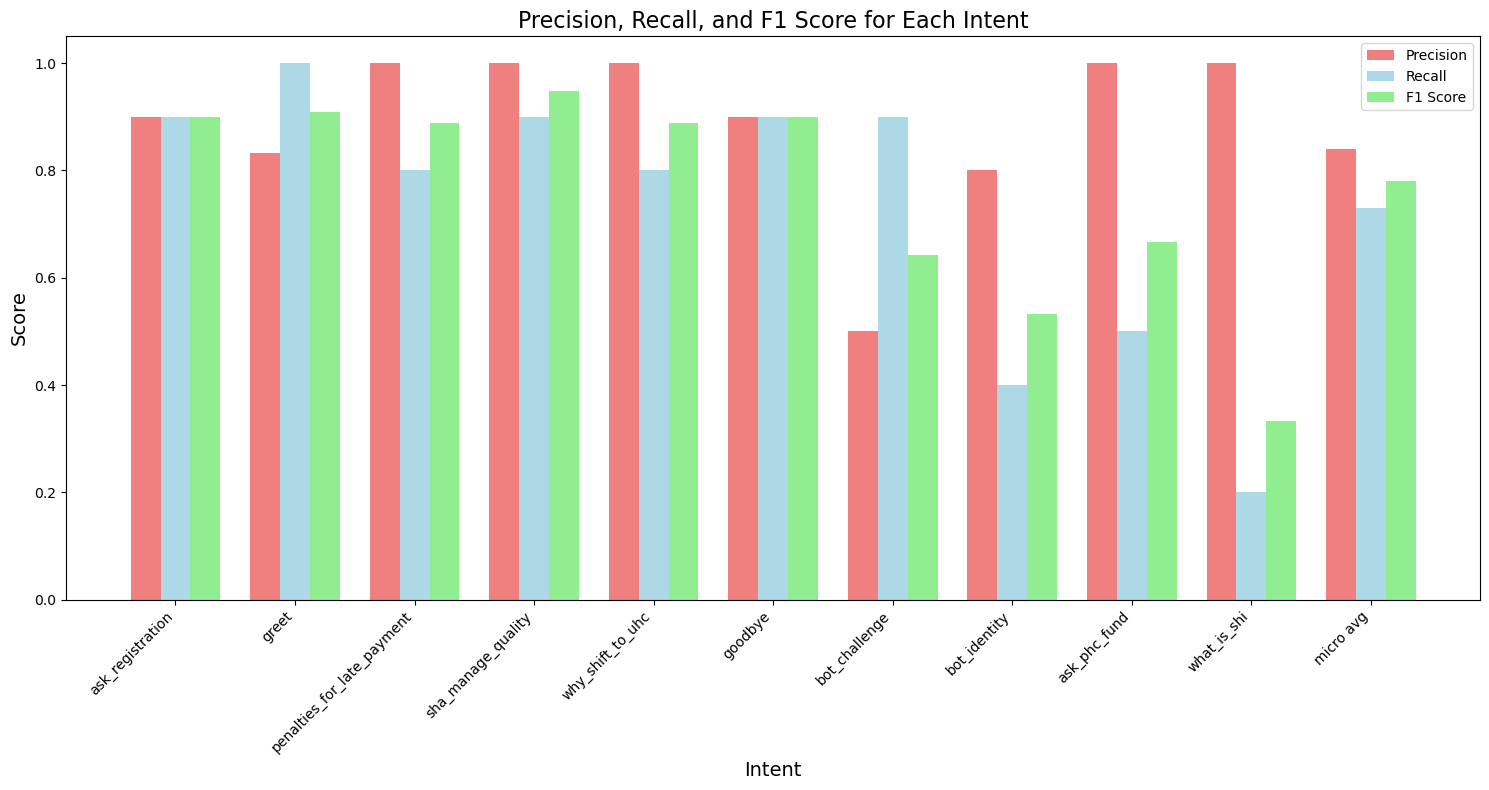

Histogram saved at: C:\Users\GeorgeC\Documents\Flatiron\phase5\capstone_project\rasa\results\intent_metrics_histogram.png


In [25]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np

# Use the updated path to the intent report
report_path = r"C:\Users\GeorgeC\Documents\Flatiron\phase5\capstone_project\rasa\results\intent_report.json"

# Check if the report path exists
if not os.path.exists(report_path):
    print(f"Error: The intent report at {report_path} was not found.")
    exit(1)

# Load the intent report
with open(report_path, "r") as f:
    report = json.load(f)

# Extract intents and metrics (precision, recall, F1-score)
intents = []
precision_scores = []
recall_scores = []
f1_scores = []

for intent, metrics in report.items():
    if intent not in ['accuracy', 'macro avg', 'weighted avg']:  # Skip summary metrics
        if 'precision' in metrics and 'recall' in metrics and 'f1-score' in metrics:
            intents.append(intent)
            precision_scores.append(float(metrics['precision']))
            recall_scores.append(float(metrics['recall']))
            f1_scores.append(float(metrics['f1-score']))
        else:
            print(f"Warning: Metrics for intent '{intent}' are incomplete. Skipping...")

# Extract overall accuracy
accuracy = report.get('accuracy', None)

if accuracy is not None:
    accuracy_percentage = accuracy * 100
    print(f"Overall Model Accuracy: {accuracy_percentage:.2f}%")
else:
    print("Accuracy information is not available in the report.")

# Check if there is any data to plot
if not intents:
    print("No intents found with valid metrics to plot.")
    exit(1)

# Set the width for each bar
bar_width = 0.25
index = np.arange(len(intents))

# Plot Precision, Recall, and F1 Score for each intent
plt.figure(figsize=(15, 8))

# Creating bars for precision, recall, and F1
plt.bar(index, precision_scores, bar_width, label='Precision', color='lightcoral')
plt.bar(index + bar_width, recall_scores, bar_width, label='Recall', color='lightblue')
plt.bar(index + 2 * bar_width, f1_scores, bar_width, label='F1 Score', color='lightgreen')

# Adding labels and titles
plt.xlabel('Intent', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.title('Precision, Recall, and F1 Score for Each Intent', fontsize=16)
plt.xticks(index + bar_width, intents, rotation=45, ha='right')
plt.legend()

# Adjust layout and save
plt.tight_layout()
histogram_path = os.path.join(os.path.dirname(report_path), 'intent_metrics_histogram.png')
plt.savefig(histogram_path)

# Show the plot
plt.show()

print(f"Histogram saved at: {histogram_path}")


## Rasa Model Improvement
To improve our Rasa models, we focused on updating and optimizing four key .yml files—config.yml, domain.yml, nlu.yml, and stories.yml.

we: 

    - Adjusted the pipeline to include advanced components for better feature extraction.
    - Cleaned up duplicate responses and refined intents.
    - Added more diverse examples to better differentiate similar intents.
    - Expanded stories to cover additional conversation paths.

## Configuration Explanation for Rasa 

## Language and Version

- **version**: `"3.1"` - Specifies the compatible Rasa version.

## Pipeline Components

The pipeline processes user messages to determine intent and extract entities.

1. **WhitespaceTokenizer**
   - Splits text by whitespace, suitable for English where words are separated by spaces.

2. **RegexFeaturizer**
   - Recognizes regex patterns like dates or phone numbers, enhancing entity recognition.

3. **LexicalSyntacticFeaturizer**
   - Adds features like word prefixes and suffixes to support intent recognition and entity extraction.

4. **CountVectorsFeaturizer**
   - Converts words into vectors based on word frequencies, essential for distinguishing between intents.

5. **DIETClassifier**
   - Main model for intent classification and entity extraction.
   - **epochs**: `200` allows sufficient training time.
   - **random_seed**: `42` ensures reproducibility.
   - **constrain_similarities**: `True` improves intent classification by reducing similarities.
   - **evaluation_metric**: `"f1"` uses F1-score for a balanced metric.
   - **early_stopping**: `True` stops training when improvements plateau.

6. **EntitySynonymMapper**
   - Maps different expressions of the same entity (e.g., "NYC" to "New York City") for consistency.

7. **ResponseSelector**
   - Manages FAQ responses.
   - **epochs**: `100` for shorter training, as it handles predefined responses.
   - **constrain_similarities**: `True` for distinct representation of FAQs.
   - **early_stopping**: `True` stops training when performance stabilizes.

8. **FallbackClassifier**
   - Triggers fallback when intent recognition confidence is low.
   - **threshold**: `0.3` specifies the confidence level for fallback.



## Policies for Dialogue Management

These policies define the bot’s response strategy based on conversation history.

1. **RulePolicy**
   - Manages rule-based responses and fallbacks.
   - **core_fallback_threshold**: `0.3` for dialogue fallbacks.
   - **core_fallback_action_name**: `"action_default_fallback"` specifies the fallback action.

2. **MemoizationPolicy**
   - Recalls exact conversation paths from training stories.
   - **max_history**: `5` defines the number of past turns considered.

3. **TEDPolicy**
   - Transformer-based model for flexible dialogue management.
   - **epochs**: `200` allows deeper learning of conversation patterns.
   - **max_history**: `5` defines the past actions and intents to consider.
   - **random_seed**: `42` for reproducibility.
   - **evaluation_metric**: `"f1"` monitors F1-score for balanced performance.
   - **early_stopping**: `True` halts training when performance plateaus.


### Model Testing and Evaluation

After completing the model training phase, we proceeded to evaluate the model's performance - the accuracy improved from **`73%`** to **`81.19%`**

**NLU Evaluation**: We tested the trained model's ability to classify user intents and extract entities correctly by running the NLU evaluation against the test dataset (`test_nlu.yml`). The evaluation generated metrics such as **precision**, **recall**, **F1-score**, and an overall **accuracy** value for each intent. These metrics help us understand how well the model can understand and classify different user inputs.

Overall Model Accuracy: 81.19%


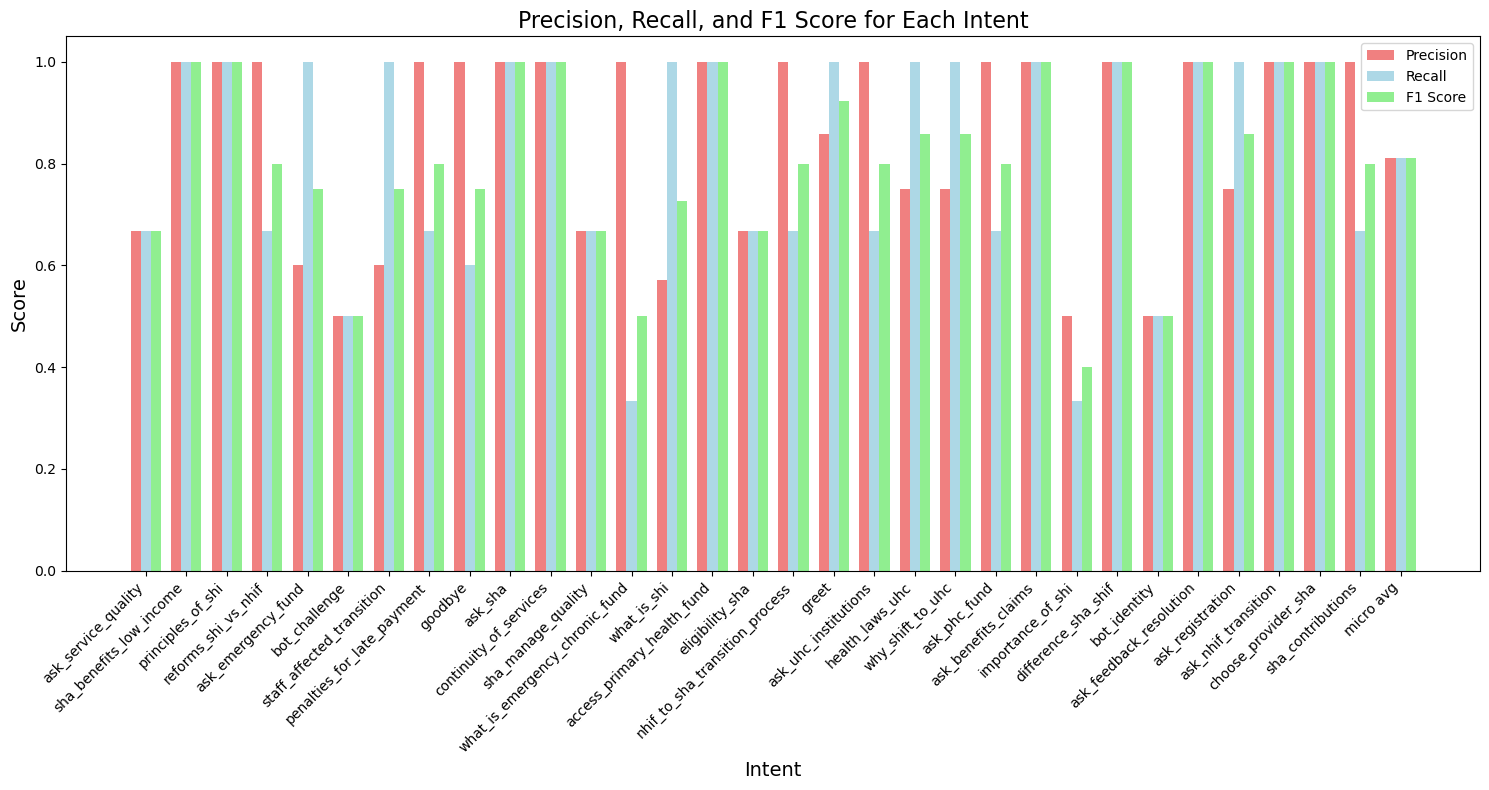

Histogram saved at: C:\Users\GeorgeC\Documents\Flatiron\phase5\capstone_project\results\intent_metrics_histogram.png


In [1]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np

# Use the exact path to the intent report
report_path = r"C:\Users\GeorgeC\Documents\Flatiron\phase5\capstone_project\results\intent_report.json"

# Check if the report path exists
if not os.path.exists(report_path):
    print(f"Error: The intent report at {report_path} was not found.")
    exit(1)

# Load the intent report
with open(report_path, "r") as f:
    report = json.load(f)

# Extract intents and metrics (precision, recall, F1-score)
intents = []
precision_scores = []
recall_scores = []
f1_scores = []

for intent, metrics in report.items():
    if intent not in ['accuracy', 'macro avg', 'weighted avg']:  # Skip summary metrics
        if 'precision' in metrics and 'recall' in metrics and 'f1-score' in metrics:
            intents.append(intent)
            precision_scores.append(float(metrics['precision']))
            recall_scores.append(float(metrics['recall']))
            f1_scores.append(float(metrics['f1-score']))
        else:
            print(f"Warning: Metrics for intent '{intent}' are incomplete. Skipping...")

# Extract overall accuracy
accuracy = report.get('accuracy', None)

if accuracy is not None:
    accuracy_percentage = accuracy * 100
    print(f"Overall Model Accuracy: {accuracy_percentage:.2f}%")
else:
    print("Accuracy information is not available in the report.")

# Check if there is any data to plot
if not intents:
    print("No intents found with valid metrics to plot.")
    exit(1)

# Set the width for each bar
bar_width = 0.25
index = np.arange(len(intents))

# Plot Precision, Recall, and F1 Score for each intent
plt.figure(figsize=(15, 8))

# Creating bars for precision, recall, and F1
plt.bar(index, precision_scores, bar_width, label='Precision', color='lightcoral')
plt.bar(index + bar_width, recall_scores, bar_width, label='Recall', color='lightblue')
plt.bar(index + 2 * bar_width, f1_scores, bar_width, label='F1 Score', color='lightgreen')

# Adding labels and titles
plt.xlabel('Intent', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.title('Precision, Recall, and F1 Score for Each Intent', fontsize=16)
plt.xticks(index + bar_width, intents, rotation=45, ha='right')
plt.legend()

# Adjust layout and save
plt.tight_layout()
histogram_path = os.path.join(os.path.dirname(report_path), 'intent_metrics_histogram.png')
plt.savefig(histogram_path)

# Show the plot
plt.show()

print(f"Histogram saved at: {histogram_path}")


### Conclusion
This chatbot project provides substantial value by enhancing customer support for SHA. Its deployment has the potential to improve access to health insurance information, streamline service operations, and ultimately support SHA's mission to provide accessible healthcare coverage for Kenyans.